In [1]:
import subprocess
import os 
import re
import numpy as np
import pandas as pd
import plotly.express as px
import hdbscan
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score, contingency_matrix

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [3]:
pockets_order = pd.read_excel('pockets_order.xlsx')
total_pocks=list(pockets_order[0])

In [4]:
pockets_order

,Unnamed: 0,0
0,0,1blx_pocket1.pdb
1,1,1byg_pocket1.pdb
2,2,1fmk_pocket1.pdb
3,3,1fmk_pocket2.pdb
4,4,1j1b_pocket1.pdb
...,...,...
271,271,6fyr_pocket1.pdb
272,272,6fyv_pocket1.pdb
273,273,6gzm_pocket1.pdb
274,274,6op9_pocket1.pdb


In [5]:
len(total_pocks)

276

In [6]:
# simil_matrix = np.ones((len(total_pocks),len(total_pocks)))
# simil_matrix = np.ones((len(total_pocks),len(total_pocks)))
# for i in range(len(total_pocks)):
#     for j in range(i+1,len(total_pocks)):
#         print(str(i) +" "+ str(j)+"   "+str(total_pocks[i])+" "+str(total_pocks[j]),end="\r")
#         command = "./find_similarities.sh pockets70/"+str(total_pocks[i])+" pockets70/"+str(total_pocks[j])
# #         print(sp.getoutput(command))
#         simil_matrix[i,j] = simil_matrix[j,i] = float(sp.getoutput(command))
# #         simil_matrix[i,j] = simil_matrix[j,i] = float(sp.getoutput("./find_similarities.sh pocket10.pdb pocket8.pdb"))

In [7]:
simil_matrix = pd.read_excel('simil_matrix30_final.xlsx')
simil_matrix = simil_matrix.drop(['Unnamed: 0'], axis=1)

In [8]:
disim_conversion = lambda t: 1 - t
disimil_matrix = disim_conversion(simil_matrix)

In [9]:
disimil_matrix

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,275
0,0.00000,0.81243,1.00000,0.85563,0.64824,0.75064,0.90988,0.68283,0.88259,0.86237,...,0.72379,0.73411,0.74061,0.87213,0.74235,0.70489,0.73853,0.75480,0.83235,0.72857
1,0.81243,0.00000,1.00000,0.84858,0.53176,0.61954,0.82821,0.60849,0.63961,0.83274,...,0.64579,0.59641,0.58089,1.00000,0.61287,0.60338,0.60151,0.67830,0.53244,0.61692
2,1.00000,1.00000,0.00000,0.84614,0.53596,0.51079,0.88530,1.00000,1.00000,0.79435,...,1.00000,1.00000,1.00000,0.50646,0.54051,0.58036,0.55496,1.00000,0.45071,1.00000
3,0.85563,0.84858,0.84614,0.00000,0.87495,0.82614,0.86552,0.83795,0.86961,0.87979,...,0.81617,0.82969,0.88110,0.85302,0.83548,0.86876,0.83688,0.82378,0.83978,0.87588
4,0.64824,0.53176,0.53596,0.87495,0.00000,0.41628,0.86974,0.56940,0.57650,0.84392,...,0.47961,0.60347,0.55960,0.40710,0.37040,0.32514,0.30593,0.61885,0.47749,0.84222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0.70489,0.60338,0.58036,0.86876,0.32514,0.39888,0.84216,0.54635,0.64744,0.87102,...,0.49362,0.54557,0.50186,0.40550,0.28839,0.00000,0.26356,0.56338,0.50601,0.61857
272,0.73853,0.60151,0.55496,0.83688,0.30593,0.27159,0.86403,0.60205,0.56354,0.81008,...,0.45742,0.64318,0.52827,0.21865,0.15904,0.26356,0.00000,0.63106,0.52621,0.83999
273,0.75480,0.67830,1.00000,0.82378,0.61885,0.79128,0.85971,0.66940,0.74250,0.85558,...,0.72470,0.73384,0.72319,1.00000,0.67997,0.56338,0.63106,0.00000,0.65285,0.73147
274,0.83235,0.53244,0.45071,0.83978,0.47749,0.51073,0.88741,0.57022,0.55299,0.84032,...,0.59369,0.60493,0.54736,0.51898,0.53704,0.50601,0.52621,0.65285,0.00000,0.55936


## Clustering - Searching for number of clusters

In [10]:
kinase_names = []
count = 0
for kinase in total_pocks:
    kin_name = str(kinase[:4])+"_"+re.findall(r'[0-9]+', total_pocks[count][4:])[0]
    kinase_names.append(kin_name)
    count = count + 1

In [11]:
def create_manifold(labels):
    final_clusters = []
    final_clusters.append(kinase_names)
    final_clusters.append(list(labels))
    final_clusters = np.transpose(final_clusters)
    data_pockets_manifold = pd.DataFrame(final_clusters, columns= ['Pockets', 'Clusters'])
    data_pockets_manifold["x"] = mds_coords[:,0]
    data_pockets_manifold["y"] = mds_coords[:,1]
#     data_pockets_manifold["z"] = mds_coords[:,2]
    return data_pockets_manifold

In [12]:
import numpy as np  
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
from sklearn import manifold  # multidimensional scaling
from matplotlib.pyplot import figure



In [13]:
def create_clusters_file(labels,clusters,e,s):
    
    final_clusters = []
    final_clusters.append(kinase_names)
    final_clusters.append(list(labels))
    final_clusters = np.transpose(final_clusters)
    df = pd.DataFrame(final_clusters, columns= ['Kinase', 'Cluster'])
    num_clust = len(np.unique(np.array(labels)))
    

  
    for i in range(num_clust):
        df1 = df[df["Cluster"] == str(i)]
        df1.to_excel("Pockets30_HDBScan/Cluster"+str(num_clusters)+"_min_cluster"+str(e)+"_min_sample"+str(s)+"/Clusters_"+str(i)+".xlsx", index = False, header=True)
        
    df.to_excel("Pockets30_HDBScan/Pockets30_Clusters_"+str(clusters)+"_min_cluster"+str(e)+"_min_sample"+str(s)+".xlsx", index = False, header=True)


In [14]:
def create_histogram(labels,i):
# a histogram returns 3 objects : n (i.e. frequncies), bins, patches
    freq, bins, patches = plt.hist(labels, edgecolor='white', label='kinases', bins=i)

    # x coordinate for labels
    bin_centers = np.diff(bins)*0.5 + bins[:-1]

    n = 0
    for fr, x, patch in zip(freq, bin_centers, patches):
      height = int(freq[n])
      plt.annotate("{}".format(height),
                   xy = (x, height),             # top left corner of the histogram bar
                   xytext = (0,0.2),             # offsetting label position above its bar
                   textcoords = "offset points", # Offset (in points) from the *xy* value
                   ha = 'center', va = 'bottom'
                   )
      n = n+1

    plt.legend()
    plt.gca().set(title=str(i)+' Clusters Frequency Histogram', ylabel='Frequency');
    plt.show

In [15]:
def funk(df, method):
    import warnings
    warnings.filterwarnings('ignore')  
    global data_leaf, data_eom
    n = df.shape[0]
    print(n)
    list_name =[]
    for gamma in range (1, int(np.log(n))):
        for ms in range(1, int(2 * np.log(n))):
            clust_alg = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=True, 
                                    leaf_size=40,
                                    cluster_selection_method=method,
                                    metric='precomputed', 
                                    min_cluster_size=int(gamma * np.sqrt(n)), 
                                    min_samples=ms,
                                    allow_single_cluster=False).fit(df)
 
            min_cluster_size = clust_alg.min_cluster_size 
            min_samples = clust_alg.min_samples
            validity_score = clust_alg.relative_validity_
            n_clusters = np.max(clust_alg.labels_) 
            list_name.append((min_cluster_size, min_samples, validity_score, n_clusters))
            if validity_score >= .5:
                print (f'min_cluster_size = {min_cluster_size},  min_samples = {min_samples}, validity_score = {validity_score} n_clusters = {n_clusters}')
    return list_name
def best_validity(source):
    cols = ['min_cluster_size', 'min_samples', 'validity_score', 'n_clusters']
    df =  pd.DataFrame(source, columns = cols)
    best_validity = df.loc[df['validity_score'].idxmax()]
    return best_validity


data_leaf = []
data_eom = []

<AxesSubplot:ylabel='$\\lambda$ value'>

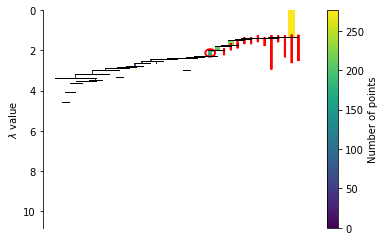

In [18]:
cluster.condensed_tree_.plot(select_clusters=True)

In [19]:
atp_pocks = pd.read_excel('atp_pockets.xlsx', columns= ['Pockets', 'Clusters'])
atp_pocks = atp_pocks.drop(['Unnamed: 0'], axis=1)
atp_pocks.columns = ['Kinase', 'atp']
atp_pocks_dic = atp_pocks.set_index('Kinase').T.to_dict('list')
print(len(atp_pocks_dic))

276


In [20]:
atp_pocks_array = np.array(atp_pocks)

In [21]:
len(atp_pocks_array)

276

In [22]:
atp_pocks_array

array([['1blx_1', 'atp'],
       ['1byg_1', 'atp'],
       ['1fmk_1', 'atp'],
       ['1fmk_2', 'non_atp'],
       ['1j1b_1', 'atp'],
       ['1o6l_1', 'atp'],
       ['1p4o_1', 'atp'],
       ['1qpc_1', 'atp'],
       ['1s9i_1', 'atp'],
       ['1tki_1', 'non_atp'],
       ['1u59_1', 'atp'],
       ['1u59_2', 'non_atp'],
       ['1ua2_1', 'atp'],
       ['1vzo_1', 'atp'],
       ['1wak_1', 'non_atp'],
       ['1x8b_1', 'non_atp'],
       ['1xjd_1', 'atp'],
       ['1xjd_2', 'non_atp'],
       ['2a2a_1', 'atp'],
       ['2ac3_1', 'non_atp'],
       ['2acx_1', 'non_atp'],
       ['2acx_2', 'non_atp'],
       ['2buj_1', 'non_atp'],
       ['2cmw_1', 'atp'],
       ['2dq7_1', 'atp'],
       ['2dq7_2', 'atp'],
       ['2eva_1', 'atp'],
       ['2f57_1', 'atp'],
       ['2fst_1', 'non_atp'],
       ['2h6d_1', 'atp'],
       ['2hw6_1', 'non_atp'],
       ['2i0e_1', 'atp'],
       ['2izr_1', 'non_atp'],
       ['2j0i_1', 'atp'],
       ['2jam_1', 'atp'],
       ['2jc6_1', 'non_atp'],
       [

In [23]:
mds_model = manifold.MDS(n_components = 2, random_state = 6867,
    dissimilarity = 'precomputed')
mds_fit = mds_model.fit(disimil_matrix)  
mds_coords = mds_model.fit_transform(disimil_matrix)

Successfully created the directory /home/user/Documents/algorithms_in_structural_biology/Final/Pockets30_HDBScan
~~~~~~~~~~~~~~~~~~~~~~~ Cluster Outliers ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Outliers 0.0
1byg_1    0.0    12    ['atp']
1j1b_1    0.0    12    ['atp']
1o6l_1    0.0    12    ['atp']
1u59_2    0.0    7    ['non_atp']
1wak_1    0.0    12    ['non_atp']
1x8b_1    0.0    12    ['non_atp']
1xjd_2    0.0    4    ['non_atp']
2acx_2    0.0    10    ['non_atp']
2qol_1    0.0    12    ['non_atp']
2r4b_1    0.0    12    ['atp']
2rei_1    0.0    12    ['atp']
2vd5_1    0.0    12    ['atp']
2vz6_2    0.0    6    ['non_atp']
2wel_2    0.0    6    ['non_atp']
2x7g_1    0.0    12    ['non_atp']
2xir_1    0.0    12    ['atp']
2xir_2    0.0    11    ['atp']
2xrw_1    0.0    12    ['atp']
2ycf_1    0.0    12    ['atp']
3b2t_1    0.0    12    ['atp']
3bhy_1    0.0    12    ['atp']
3cbl_1    0.0    12    ['atp']
3com_1    0.0    12    ['atp']
3e7o_1    0.0    7    ['non_atp']
3eqc_1    

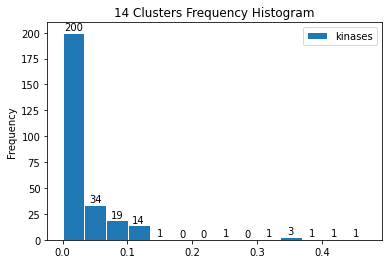

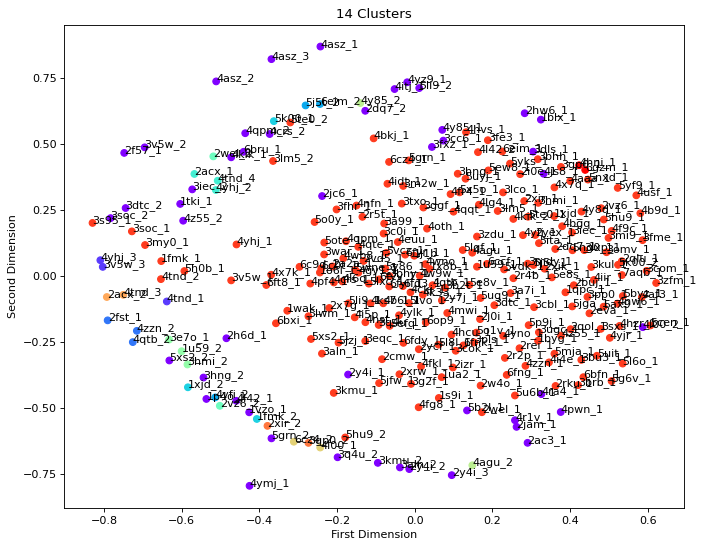

In [25]:
silhouette_totals = []
path = "/home/user/Documents/algorithms_in_structural_biology/Final/Pockets30_HDBScan"
try:
    os.makedirs(path, exist_ok=True)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print("Successfully created the directory %s" % path)
    
for i in range(2,3):
    for j in range(1,2):
    #     eps=0.5, min_samples=3  4 clusters
    # eps=0.5, min_samples=5 2 clusters
        cluster = hdbscan.HDBSCAN(metric='precomputed',min_cluster_size=i, min_samples=j).fit(disimil_matrix)
        new_labels_ = [x+1 for x in cluster.labels_]
#         print(new_labels_)
        unique_labels = np.unique(np.array(new_labels_))
        num_clusters = len(unique_labels)
        if num_clusters > 1 and num_clusters<30:
#             create_histogram(new_labels_,num_clusters)
            path = "/home/user/Documents/algorithms_in_structural_biology/Final/Pockets30_HDBScan/Cluster"+str(num_clusters)+"_min_cluster"+str(i)+"_min_sample"+str(j)
            try:
                os.makedirs(path, exist_ok=True)
            except OSError:
                print ("Creation of the directory %s failed" % path)
                
            max_score = max(cluster.outlier_scores_)
            min_score = min(cluster.outlier_scores_)
            create_histogram(cluster.outlier_scores_,14)
            print("~~~~~~~~~~~~~~~~~~~~~~~ Cluster Outliers ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            
            print(color.CYAN + "Outliers 0.0"+ color.END)
            for out1 in range(len(cluster.outlier_scores_)):
                if cluster.outlier_scores_[out1]== 0.0:
                    print(str(kinase_names[out1])+"    "+str(cluster.outlier_scores_[out1])+"    "+str(new_labels_[out1])+"    "+str(atp_pocks_dic[kinase_names[out1]]))
                    
            print(color.CYAN + "Outliers 0.1 - 0.2"+ color.END)
            for out1 in range(len(cluster.outlier_scores_)):
                if cluster.outlier_scores_[out1]>0.1 and cluster.outlier_scores_[out1]<0.2:
                    print(str(kinase_names[out1])+"    "+str(cluster.outlier_scores_[out1])+"    "+str(new_labels_[out1])+"    "+str(atp_pocks_dic[kinase_names[out1]]))
            print(color.DARKCYAN + "Outliers > 0.2"+ color.END)
            for out2 in range(len(cluster.outlier_scores_)):
                if cluster.outlier_scores_[out2]>0.2:
                    print(str(kinase_names[out2])+"    "+str(cluster.outlier_scores_[out2])+"    "+str(new_labels_[out2])+"    "+str(atp_pocks_dic[kinase_names[out2]]))
                
            print("max_score "+str(max_score)+" min_score "+str(min_score))
            create_clusters_file(new_labels_,num_clusters,i,j)
            print("~~~~~~~~~~~~~~~~~~~~~~~ Cluster "+str(num_clusters)+" min_cluster = "+str(i)+" min_sample = "+str(j)+"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
            ########## plot 4 #################
#             cluster.condensed_tree_.plot(select_clusters=True)
#             cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
#             plt.show
            ###### plot 1 ################
            data_kinases_manifold = create_manifold(new_labels_)
            fig = px.scatter(data_kinases_manifold, x="x", y="y", color="Clusters", hover_data=["Pockets"],title=str(num_clusters)+' Clusters')
            fig.write_html("hdbscan2D.html")
            fig.show()
            ###### plot 2 ################
        #     fig = px.scatter_3d(data_kinases_manifold, x='x', y='y', z='z',
        #               color="Clusters",range_z = (0, 300),hover_data=["Pockets"], title=str(i)+' Clusters')
        #     fig.show()
            ##### plot 3 ###############
            plt.figure(figsize=(10, 8), dpi=80)
            plt.scatter(mds_coords[:,0],mds_coords[:,1], c=new_labels_, cmap='rainbow')
            #     facecolors = 'red', edgecolors = 'none')  # points in white (invisible)
            labels = kinase_names
            for label, x, y in zip(labels, mds_coords[:,0], mds_coords[:,1]):
                plt.annotate(label, (x,y), xycoords = 'data')
            plt.xlabel('First Dimension')
            plt.ylabel('Second Dimension')
            plt.title(str(num_clusters)+" Clusters")   
            plt.show()

        #     silhouette_totals.append(metrics.silhouette_score(disimil_matrix, cluster.labels_, metric='precomputed'))

In [73]:
for i in range(14):
    print(color.DARKCYAN + "Cluster "+str(i)+ color.END)
    for j in range(len(new_labels_)):
        if new_labels_[j] == i:
            print(str(kinase_names[j])+"    "+str(cluster.outlier_scores_[j])+"    "+str(new_labels_[j])+"    "+str(atp_pocks_dic[kinase_names[j]]))

Cluster 0
1blx_1    0.09410095026533377    0    ['atp']
1p4o_1    0.008902618830302713    0    ['atp']
1tki_1    0.027107386956017953    0    ['non_atp']
1vzo_1    0.02245949436182806    0    ['atp']
2ac3_1    0.07151327335683903    0    ['non_atp']
2dq7_2    0.075270849080373    0    ['atp']
2f57_1    0.026611823225559314    0    ['atp']
2h6d_1    0.02487686145236406    0    ['atp']
2hw6_1    0.02377231771785748    0    ['non_atp']
2jam_1    0.028536452215917545    0    ['atp']
2jc6_1    0.03983770522740138    0    ['non_atp']
2y4i_1    0.023248224227298633    0    ['atp']
2y4i_2    0.017955747268309626    0    ['non_atp']
2y4i_3    0.008958283604094341    0    ['non_atp']
3aln_2    0.012786210790970374    0    ['non_atp']
3cc6_1    0.0353478554250222    0    ['atp']
3dls_1    0.06816724968407159    0    ['atp']
3dtc_2    0.001270946440659261    0    ['non_atp']
3fxz_1    0.029822855290505643    0    ['atp']
3hng_2    0.08507462686567158    0    ['atp']
3iec_2    0.0016378501895415228

In [ ]:
silhouette_totals

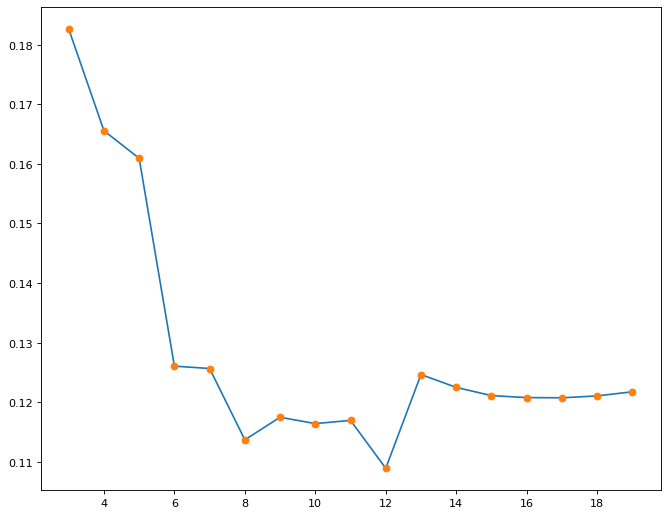

In [25]:
import numpy as np
import matplotlib.pyplot as plt

x = range(3, 20)
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(x, silhouette_totals)
plt.plot(x, silhouette_totals, 'o')
plt.show()

<AxesSubplot:ylabel='$\\lambda$ value'>

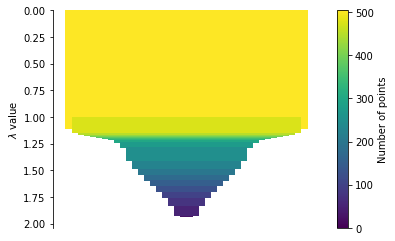

In [44]:
            ########## plot 4 #################
cluster.condensed_tree_.plot(select_clusters=True)